#### Using pre-trained AlexNet model and fine-tune it

<img src=../images/AlexNet.png width=350>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
torch.use_deterministic_algorithms(True) # ensure the reproducibility

In [9]:
class AlexNet:
    def __init__(self, number_of_classes):
        super(AlexNet, self).__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(3, 64, 11, 4, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.clf = nn.Linear(in_features=256, out_features=number_of_classes)

    def forward(self, inp):
        op = self.feats(inp) # pass the input through the feature extractor
        op = op.view(op.size(0), -1) # flatten the output
        op = self.clf(op) # pass the output through the classifier
        return op

#### using pre-trained AlexNet model.

In [10]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
torch.use_deterministic_algorithms(True) # ensure the reproducibility

In [11]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("ajayrana/hymenoptera-data")

# print("Path to dataset files:", path)

In [12]:
ddir = './data/versions/1/hymenoptera_data'
# Data augmentation and normalization for training
# Just normalization for validation
# the mean and std for nomalization are calculated as
# the mean of all pixel values for all images in the training
# set per each image channel R-G-B
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]),
}

img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transforms[k]) for k in ['train', 'val']}
dloader = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True) for k in ['train', 'val']}
dataset_sizes = {k: len(img_data[k]) for k in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

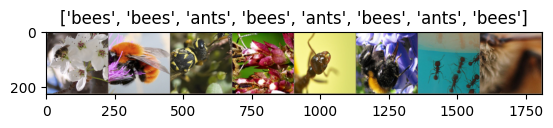

In [13]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
img, cls = next(iter(dloader['train']))
grid = torchvision.utils.make_grid(img)
imageshow(grid, text=[classes[c] for c in cls])

In [25]:
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    start = time.time()

    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        # for each epoch we run through the training and validation set
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # set model to train mode (i.e. trainbale weights)
            else:
                pretrained_model.eval()   # set model to validation mode

            loss = 0.0
            successes = 0

            # iterate over the (training/validation) data.
            for imgs, tgts in dloader[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()
                
                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dataset_sizes[dset]
            accuracy_epoch = successes.double() / dataset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

In [29]:
def visualize_predictions(pretrained_model, num_of_images=4):
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    img_counter = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (img, tgt) in enumerate(dloader['val']):
            img = img.to(dvc)
            tgt = tgt.to(dvc)
            op = pretrained_model(img)
            _, preds = torch.max(op, 1)
            # Displays num_of_images images along with their predicted class.
            for j in range(img.size()[0]):
                img_counter += 1
                ax = plt.subplot(num_of_images//2, 2, img_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgt[j]]}')
                imageshow(img.cpu().data[j])
                if img_counter == num_of_images:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [16]:
model_finetune = models.alexnet(pretrained=True)

/Users/lyteatnyte/Dev/github/Algorithms/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lyteatnyte/Dev/github/Algorithms/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/lyteatnyte/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [04:52<00:00, 836kB/s]  


In [17]:
print(model_finetune.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [18]:
print(model_finetune.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [19]:
model_finetune.classifier[6] = nn.Linear(in_features=4096, out_features=len(classes))

In [26]:
loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.001)
model_finetune = finetune_model(model_finetune, loss_func, optim_finetune, epochs=10)

Epoch number 0/9
train loss in this epoch: 0.2954074371545041, accuracy in this epoch: 0.8647540983606558
val loss in this epoch: 0.25268463919767076, accuracy in this epoch: 0.9215686274509803

Epoch number 1/9
train loss in this epoch: 0.2389067816929739, accuracy in this epoch: 0.8934426229508197
val loss in this epoch: 0.24479345412425746, accuracy in this epoch: 0.9150326797385621

Epoch number 2/9
train loss in this epoch: 0.18639877646184358, accuracy in this epoch: 0.9508196721311475
val loss in this epoch: 0.23127650492672436, accuracy in this epoch: 0.9150326797385621

Epoch number 3/9
train loss in this epoch: 0.20034040406834883, accuracy in this epoch: 0.9385245901639344
val loss in this epoch: 0.2376001821526515, accuracy in this epoch: 0.934640522875817

Epoch number 4/9
train loss in this epoch: 0.213376235583278, accuracy in this epoch: 0.9262295081967213
val loss in this epoch: 0.2295569478369811, accuracy in this epoch: 0.9281045751633987

Epoch number 5/9
train loss

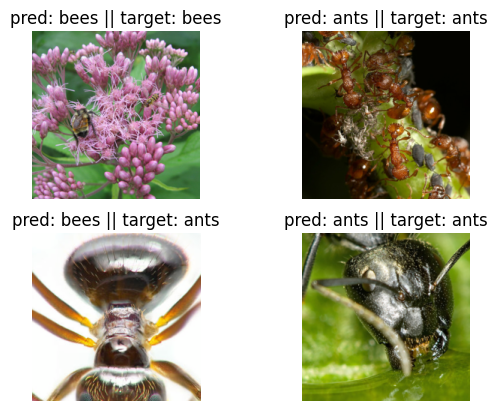

In [30]:
visualize_predictions(model_finetune)